# Auto encoders
In this exercise you'll experiment with autoencoders. Autoencoers are models that tries to reconstruct the its input. Typically you'll force the model to do some sort of compression either by having a relatively narrow hidden layer or by injecting noise into the model.

In the exercise we'll provide the code for a vanilla autoencoder. 


The vanilla auto encoder implements

$$
\begin{align}
z_{enc} &= xW_1+b_1 \\
z_{hidden} &= \sigma(z_{enc}) \\
z_{dec} &= z_{hidden} W_2 + b_2 \\
x_{recon} &= \sigma(z_{dec})
\end{align}
$$

Here $\sigma$ can be any activation function and you may have more hidden layers in both the encoder and the decoder.
For some autoencoders you'll see that the encoder and decoder share weights such that the decoder weights are $W^T_{enc}$ (T=transposed).

**Reference:** http://papers.nips.cc/paper/3048-greedy-layer-wise-training-of-deep-networks.pdf

Note that the vanialla autoencoder is outdated and is mostly of historical intererest, because it has been used for pretraining deeper networks. Hugo larochelle has a good lecture on why pretraining might help: http://www.youtube.com/watch?v=35MUlYCColk


In the code we provide we'll train a two layer vanialla autoencoder. We'll then use TSNE to plot the representation that the autoencoder has learnt. TSNE can be used in place of PCA but often works better when working with high dimensions.


###Your task is to modify the code to an denosing autoencoder

The denoising autoencoder tries to do the reconstruction from noisy input:

$$
\begin{align}
x_{noise} &= x + N(0, v) \\
z_{enc} &= x_{noise}W_1+b_1 \\
z_{hidden} &= \sigma(z_{enc}) \\
z_{dec} &= z_{hidden} W_2 + b_2 \\
x_{recon} &= \sigma(z_{dec})
\end{align}
$$

Here we have shown guassian noise with variance $v$. You could also use dropout noise.

**Reference**: http://www.iro.umontreal.ca/~vincentp/Publications/denoising_autoencoders_tr1316.pdf

### Sampling from VAE

The autoencoders in this exercise are deterministic models. The Variational autoencoder from yesterday is a generative model. We have prepared a notebook that shows how you can sample from variational autoencoder. 
see the notebook **`vae_sampling_from_manifold`**.
The VAE learns a very nice low dimensional representation of the data...go have a look :) 

(If you are not comfortable with the variational bound then Hugo Larochelle has another nice lecture on that  http://www.youtube.com/watch?v=pStDscJh2Wo)

### Autoencoder code

In [74]:
from __future__ import print_function # for py 3
import os
#os.environ['THEANO_FLAGS'] = 'device=gpu0, floatX=float32'
from lasagne.layers import DenseLayer
import lasagne
import theano.tensor as T
import numpy as np
import theano

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt


In [75]:
num_inputs = 784
num_units = 400
num_classes = 10
num_batch = 256
x_sym = T.matrix()


# define autoencoder
l_in = lasagne.layers.InputLayer((num_batch, num_inputs))
l_enc1 = lasagne.layers.DenseLayer(l_in, num_units=num_units, W=lasagne.init.HeUniform('relu'))
l_enc2 = lasagne.layers.DenseLayer(l_enc1, num_units=num_units, nonlinearity=None, W=lasagne.init.HeUniform('relu'))  # linear
l_dec1 = lasagne.layers.DenseLayer(l_enc2, num_units=num_units, W=lasagne.init.HeUniform('relu'))
l_dec2 = lasagne.layers.DenseLayer(l_dec1, num_units=num_inputs, nonlinearity=lasagne.nonlinearities.sigmoid, W=lasagne.init.HeUniform())

In [10]:
def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

## load data
data = np.load('mnist.npz')
x_train = (data['X_train'] > 0.5).astype('float32')
targets_train = data['y_train']
targets_train = onehot(targets_train, num_classes)

x_valid = (data['X_valid'] > 0.5).astype('float32')
targets_valid = data['y_valid']
targets_valid = onehot(targets_valid, num_classes)

x_test = data['X_test']
targets_test = (data['y_test'] > 0.5).astype('float32')
targets_test = onehot(targets_test, num_classes)

In [11]:
x_recon_train, latent_train = lasagne.layers.get_output([l_dec2, l_enc2], x_sym, deterministic=False)
x_recon_test, latent_test = lasagne.layers.get_output([l_dec2, l_enc2], x_sym, deterministic=True)

cost_train = T.mean(T.nnet.binary_crossentropy(x_recon_train.flatten()+1e-6, x_sym.flatten()))
l2 = lasagne.regularization.regularize_network_params(l_dec2, penalty=lasagne.regularization.l2)
cost_train_reg = cost_train + 1e-6*l2
cost_test = T.mean(T.nnet.binary_crossentropy(x_recon_test.flatten()+1e-6, x_sym.flatten()))

all_params = lasagne.layers.get_all_params(l_dec2, trainable=True)

lr_sh = theano.shared(lasagne.utils.floatX(0.001))
updates = lasagne.updates.adam(cost_train_reg, all_params, learning_rate=lr_sh)

train_fun = theano.function([x_sym], [cost_train], updates=updates)
test_fun = theano.function([x_sym], [latent_test, x_recon_test, cost_test])

In [12]:
costs_batch_train = []
costs_epoch_train = []
latents_valid, recons_valid, costs_valid = [],[],[]

In [13]:
num_batches = x_train.shape[0] // num_batch
num_epochs = 40
try:
    for epoch in range(num_epochs):
        cost_epoch = []
        for b in range(num_batches):
            x_batch = x_train[b*num_batch:(b+1)*num_batch]
            cost_batch = train_fun(x_batch)
            costs_batch_train += [cost_batch]
            cost_epoch += [cost_batch]
        costs_epoch_train  += [np.mean(cost_epoch)]


        # if you have a "small" gpu you might want to calculate the validation error
        # using minibatches
        latent_valid, recon_valid, cost_valid    = test_fun(x_valid)
        latents_valid += [latent_valid]
        recons_valid += [recon_valid]
        costs_valid += [cost_valid]
        print("EPOCH {}: Train Error {} Valid Error {} Learning rate {}".format(
                epoch, np.mean(cost_epoch),cost_valid,  lr_sh.get_value()))
    
        if (epoch+1) % 10 == 0:
            # decay learning rate
            new_lr = lasagne.utils.floatX(lr_sh.get_value()*0.5)
            lr_sh.set_value(new_lr)
        
except KeyboardInterrupt:
    pass

EPOCH 0: Train Error 0.134296387434 Valid Error 0.0565404593945 Learning rate 0.0010000000475
EPOCH 1: Train Error 0.0433192029595 Valid Error 0.0324394218624 Learning rate 0.0010000000475
EPOCH 2: Train Error 0.027567833662 Valid Error 0.0232811253518 Learning rate 0.0010000000475
EPOCH 3: Train Error 0.0204052459449 Valid Error 0.0174302179366 Learning rate 0.0010000000475
EPOCH 4: Train Error 0.0155930900946 Valid Error 0.0140691800043 Learning rate 0.0010000000475
EPOCH 5: Train Error 0.0124227991328 Valid Error 0.0118597140536 Learning rate 0.0010000000475
EPOCH 6: Train Error 0.0103043969721 Valid Error 0.010294791311 Learning rate 0.0010000000475
EPOCH 7: Train Error 0.00901447422802 Valid Error 0.0112672969699 Learning rate 0.0010000000475
EPOCH 8: Train Error 0.00766820367426 Valid Error 0.0102621652186 Learning rate 0.0010000000475
EPOCH 9: Train Error 0.00665927911177 Valid Error 0.00751201994717 Learning rate 0.0010000000475
EPOCH 10: Train Error 0.00505650462583 Valid Erro

### Plotting the Error
We got a few questions about decaying the learning rate. A typical decay method is to half the learning rate when the loss stop to decrease. The decay schedule is a hyperparemter that you need to tune either manually or with e.g. random search. 

Trying to figure out if your network is training properly is generally very difficult but  
[Andrej Karpathy](http://cs231n.stanford.edu/) has a very nice course with a lot of tips and tricks. ([Richard Socher](http://cs224d.stanford.edu/) also has some nice lectures)

The plot below shows the training loss and the validation loss during training. Every 20 epoch we half the learning rate. What you'll typically see is that the loss plateau's and after a learning rate decay you'll see a decrease in the loss.

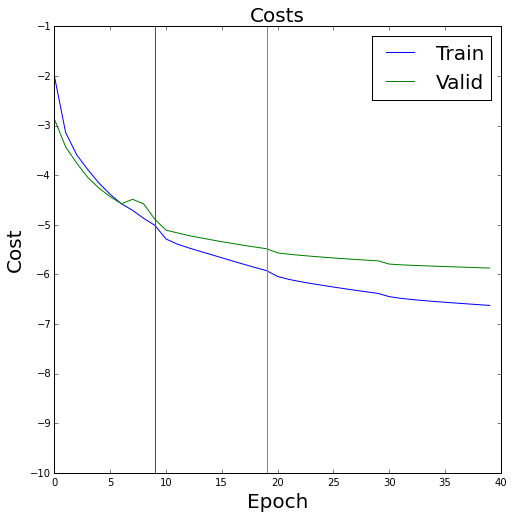

In [14]:
plt.figure(figsize=(8,8))
plt.plot(np.log(costs_epoch_train), label='Train')
plt.plot(np.log(costs_valid), label='Valid')
plt.plot([9, 9], [-10, -1])  # decay 1
plt.plot([19, 19], [-10, -1])
#plt.ylim([-7, -1])
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Cost', fontsize=20)
plt.title('Costs', fontsize=20)
plt.legend(loc=0, fontsize=20)

# plotting with t-sne
Charles blundell mentioned t-sne yesterday. For the digits in the validation set we'll use TSNE to create a two representaion of the hidden activatino. We then create a scatter plot.

**You need scikit learn to create the tsne plot**.

The result is not as clean as we would have hoped, but you might be able to increase the class seperation by using a denoising autoencoder and tuning the hyperparamters. 

Note that the sklearn implementation of TSNE seems to scale terrible with increasing number of datapoints. We therefore only plot 2000 samples. 

(If you have more datapoints in your project you can find faster implementations of TSNE)

In [70]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0, verbose=2)
nplot = 2000
Y = tsne.fit_transform(latents_valid[-1][:nplot])

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 11.148579
[t-SNE] Iteration 10: error = 15.6669666, gradient norm = 0.0701381
[t-SNE] Iteration 20: error = 16.6208677, gradient norm = 0.0715037
[t-SNE] Iteration 30: error = 17.1126547, gradient norm = 0.0733725
[t-SNE] Iteration 39: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Iteration 40: error = 17.7810222, gradient norm = 0.0705706
[t-SNE] Iteration 50: error = 17.5375847, gradient norm = 0.0764644
[t-SNE] Iteration 60: error = 18.8675606, gradient norm = 0.0742239
[t-SNE] Iteration 70: error = 19.2633010, gradient norm = 0.0722748
[t-SNE] Iteration 72: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 72 iterations with early exaggeration: 19.214227
[t-SNE] Iteration 80: error = 2.1936791, gradient norm = 0.0160657
[t-SNE] Iter

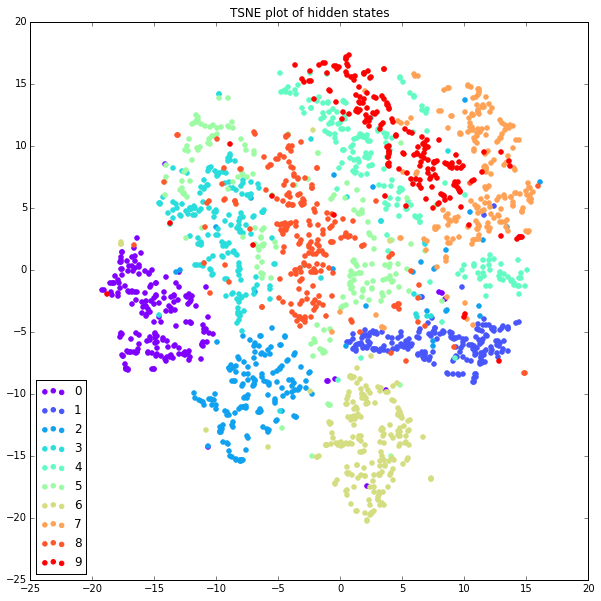

In [73]:
from matplotlib.pyplot import cm
color=iter(cm.rainbow(np.linspace(0,1,10)))
plt.figure(figsize=(10,10))
for c in range(num_classes):
    idx = np.argmax(targets_valid,axis=1)[:nplot]==c
    plt.scatter(Y[idx, 0], Y[idx, 1], color=color.next(), label=str(c))
plt.legend(loc=3)
plt.title('TSNE plot of hidden states')
plt.show()